# todos

#### testing the sampler: correctness and efficiency
- compute effective sample size: i think warne has done this to his experiement 
- could there be a chi-square way, null hypothesis etc way of testing the confidence of this sampler? 
    - this works for independent samples, probabily not good for mcmc
    - this could work for 2d. 
- moment method
- summary statistics: this is the most easy way....
- auto-correlation might also be very helpful

In [51]:
import numpy as np
from scipy import stats as ss
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import norm
from scipy import stats as ss

# Parameters for the model

In [52]:
mu = 2
sigma = 1

mu_range = (0,10)
sigma_range = (.1,10)
parameter_range = (mu_range,sigma_range)

data_size = 5

def log_likely(theta,observation): 
    return np.sum(norm.logpdf(observation,loc=theta[0],scale=np.abs(theta[1])))


# Data generation

the observation is 10 samples of the $\mathcal N(2,1)$

In [53]:
observation = np.random.normal(mu,sigma,data_size)

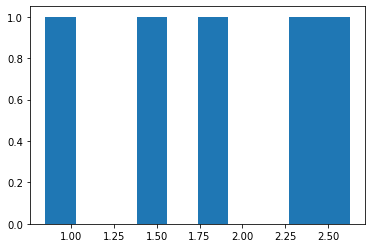

In [54]:
plt.hist(observation)
print()

# The Posterior Class

the posterior is computed as the following 

$$
\pi(\theta|X) = \frac{L(\theta|X) \pi(\theta)}{\int_{\Theta} L(\theta|X)\pi(\theta')d\theta'}
$$

#### attributes
- `prior`, $\pi(\theta)$, this is the pdf of the prior. the default is `None`, and in this case it is assumed to be uniform. 
- `parameter_range`, this is the range of the 2d parameter space. $((\theta_1^{min},\theta_1^{max}),(\theta_2^{min},\theta_2^{max}))$
- `log_likelyhood`, $\log L(\theta,X)$, should also be given by the user. 
- `evidence`, $\int_{\Theta} L(\theta|X)\pi(\theta')d\theta'$, at default is `None`, and replaced as 1. If the user input a function of X, then it will be calculated. In the case that evidence is not given, the posterior is only propotionally correct. 
- `observation`, this is simply a numpy array 

In many situations, the posterior is to the order of $\exp(-100)$, which would be rounded to zero in the float64 arithemetic, so I will provide **log-posterior** for the computation. the normal posterior will be provided as well, but it should not be used unless for graphing reasons. 

#### this only deals with
- 2d rectangular parameter space


In [55]:
class Posterior:
    
    def __init__(self, parameter_range, log_likelyhood, observation, prior=None, evidence=None):
        
        self.theta1min = parameter_range[0][0]
        self.theta1max = parameter_range[0][1]
        self.theta2min = parameter_range[1][0]
        self.theta2max = parameter_range[1][1]
        
        self.log_likelyhood = log_likelyhood
        
        self.observation = observation
        
        if evidence is None:
            self.evidence = lambda _:1
            self.prior = lambda _:1
            self.prior_sampler = lambda : (np.random.uniform(self.theta1min,self.theta1max), np.random.uniform(self.theta2min,self.theta2max))
            
        else:              
            self.evidence = evidence
            if prior is not None:
                self.prior = prior
                self.prior_sampler = None
            else:
                self.prior = lambda x: 1/((self.theta1max-self.theta1min)*(self.theta2max-self.theta2min))
        
    def log_likely(self, theta):
        return np.log(self.prior(theta)) + self.log_likelyhood(theta,self.observation) - np.log(self.evidence(theta))
    
    def likely(self, theta):
        return np.exp(self.log_likely(theta))
    
    def heatmap(self, n=(400,400),s=2):
        
        Theta1 = np.linspace(self.theta1min,self.theta1max,n[0])
        Theta2 = np.linspace(self.theta2min,self.theta2max,n[1])
        Theta = np.array([(t1,t2) for t1 in Theta1 for t2 in Theta2])
        P = [self.likely(theta) for theta in Theta]
        
        plt.figure(figsize=(10,10),)
        ax = plt.axes()
        ax.set_title('the pdf for posterior')
        ax.scatter(Theta[:,0],Theta[:,1],c=P,s=s,cmap='jet')
        ax.scatter([2],[1],s=[9])
        self.P = P
        return ax
    
    

In [56]:
pos = Posterior(parameter_range,log_likely,observation)

<AxesSubplot:title={'center':'the pdf for posterior'}>

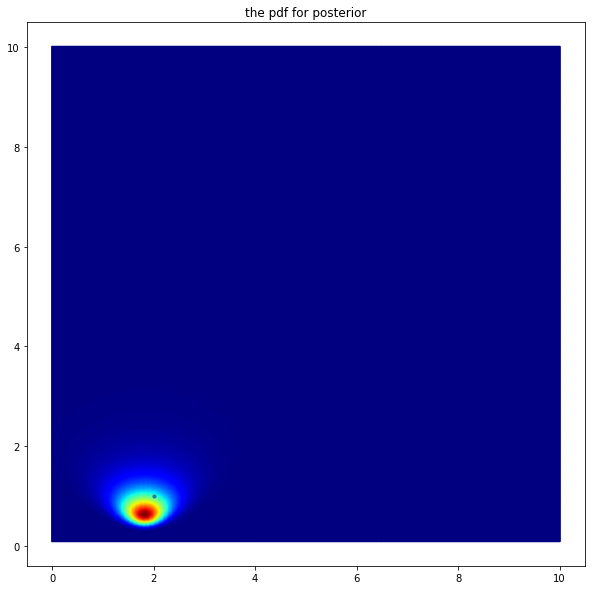

In [57]:
pos.heatmap()

this heatmap indicates that I have implemented the posterior correctly. the probability centered around $(2,1)$. 

# Sampler class

Given the Posterior object, I can sample the posterior by MCMC methods. This is what the Sampler class tries to do. 


Potential problems: 
1. I am sampling in a rectangular parameter space so that I have to not hit the boundary? Near the boundaries, the posterior is almost surely zero. So probably I don't need to really worry about it, as it is not going to be sampled anyway. 
2. The inital sample has to be choosed carefully. I should pick an initial sample with large enought likelyhood. 


#### attributes
- posterior
- burn-in=50
- n=1e5


In [58]:
class Sampler:
    '''
    Given a Posterior Object, we can sample the posterior distribution. 
    '''
    def __init__(self,posterior, burn_in=100):
        self.posterior = posterior
        self.burn_in = 100
    
    def get_init(self):
        
        '''
        this gives a random position of the prior as the starting point of the MC
        '''
        
        # if self.posterior.P is None:
        #     self.posterior.heatmap()
        
        # median = np.median(self.posterior.P)
        
        theta = self.posterior.prior_sampler()
        # while self.posterior.likely(theta) < median:
        #     theta = self.posterior.prior_sampler()
        
        return theta
    
    def proposal(self, theta):
        
        '''
        this is the proposal function. 
        it returns the proposal, and the probability ratio of the proposal log p(theta'|theta) - log p(theta|theta')
        '''
        
        theta1rg = (theta[0]-0.2, theta[0]+0.2)
        theta2rg = (theta[1]-0.2, theta[1]+0.2)
        
        theta1 = np.random.uniform(*theta1rg)
        theta2 = np.random.uniform(*theta2rg)
        
        return (theta1,theta2)
    
    def simulation(self,n=10000):
        theta = self.get_init()
        samples = [theta]
        for i in range(n+self.burn_in):
            theta_ = self.proposal(theta)
            log_likely_ratio = - self.posterior.log_likely(theta) + self.posterior.log_likely(theta_)
            log_q = log_likely_ratio
            if log_q >= 0:
                theta = theta_
            if log_q <= np.log(np.random.uniform()):
                theta = theta_
            samples.append(theta)
        return np.array(samples[-n:])

In [59]:
sampler = Sampler(pos)

In [60]:
pos_samples = sampler.simulation(n=100000)

In [61]:
XX,YY = pos_samples.T

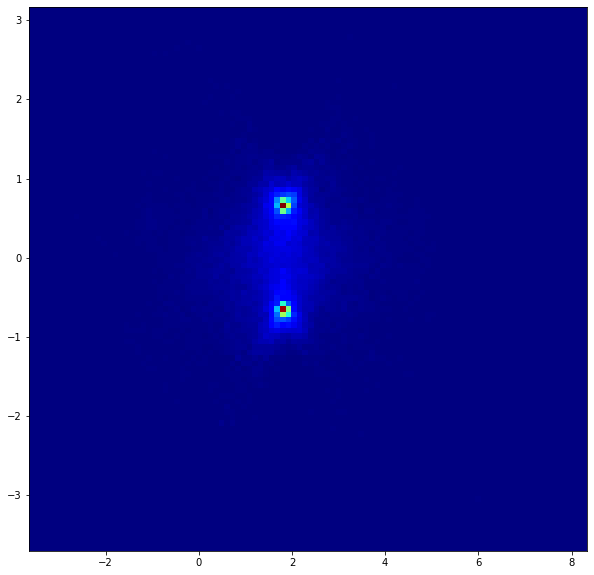

In [62]:
plt.figure(figsize=(10,10))
plt.hist2d(XX,YY,bins=(100,100),cmap='jet')
print()